<a href="https://colab.research.google.com/github/SaumilShah-7/Toxic-Comment-Classification-Challenge-Kaggle/blob/master/Toxic_Comment_Classification_(GRU%2BConv%2BFastText).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import os

import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.preprocessing import text, sequence

2.2.0


In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

 57% 15.0M/26.3M [00:00<00:00, 13.5MB/s]
100% 26.3M/26.3M [00:00<00:00, 38.7MB/s]
 73% 17.0M/23.4M [00:01<00:00, 11.0MB/s]
100% 23.4M/23.4M [00:01<00:00, 16.2MB/s]
  0% 0.00/1.46M [00:00<?, ?B/s]
100% 1.46M/1.46M [00:00<00:00, 97.7MB/s]
  0% 0.00/1.39M [00:00<?, ?B/s]
100% 1.39M/1.39M [00:00<00:00, 93.7MB/s]


In [0]:
!unzip -q -o train.csv.zip
!unzip -q -o test.csv.zip
!unzip -q -o test_labels.csv.zip
!rm train.csv.zip
!rm test.csv.zip
!rm test_labels.csv.zip

In [6]:
train = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')

print(train.shape)
print(test.shape)

(159571, 8)
(153164, 2)


In [7]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Empty comments in train dataset: 0


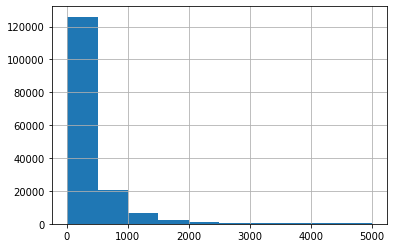

In [8]:
train.comment_text.str.len().hist()
print("Empty comments in train dataset:", len(train[train.comment_text.str.len()==0]))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


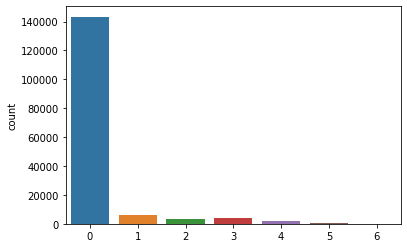

In [9]:
import seaborn as sns
sns.countplot(train[list(train.columns)[2:]].sum(axis=1))

toxic             15294
severe_toxic       1595
obscene            8449
threat              478
insult             7877
identity_hate      1405
none             143346
dtype: int64


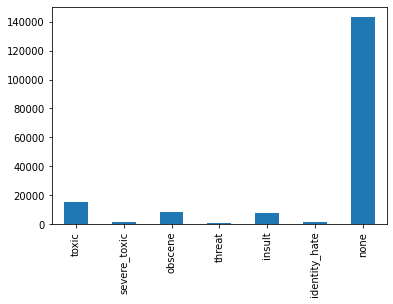

In [10]:
train['none'] = 1 - train[list(train.columns)[2:]].max(axis=1)

train[list(train.columns)[2:]].sum().plot(kind='bar')
print(train[list(train.columns)[2:]].sum())

In [0]:
max_features = 70000

In [12]:
t = text.Tokenizer(num_words=max_features)
t.fit_on_texts(train['comment_text'])

print(len(t.word_index))

210337


In [13]:
X_train = t.texts_to_sequences(train['comment_text'])
X_test = t.texts_to_sequences(test['comment_text'])

print(X_train[0])

[688, 75, 1, 126, 130, 177, 29, 672, 4511, 12052, 1116, 86, 331, 51, 2278, 11448, 50, 6864, 15, 60, 2756, 148, 7, 2937, 34, 117, 1221, 15190, 2825, 4, 45, 59, 244, 1, 365, 31, 1, 38, 27, 143, 73, 3462, 89, 3085, 4583, 2273, 985]


In [14]:
maxlen = 150
x_train = sequence.pad_sequences(X_train, maxlen=maxlen)
x_test = sequence.pad_sequences(X_test, maxlen=maxlen)

y_train = train[list(train.columns)[2:-1]]

print(x_train.shape, y_train.shape)
print(x_test.shape)

(159571, 150) (159571, 6)
(153164, 150)


In [1]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip

--2020-05-17 04:00:35--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 2606:4700:10::6816:4b8e, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1523785255 (1.4G) [application/zip]
Saving to: ‘crawl-300d-2M.vec.zip’

crawl-300d-2M.vec.z 100%[===================>]   1.42G  11.1MB/s    in 2m 13s  

2020-05-17 04:02:48 (11.0 MB/s) - ‘crawl-300d-2M.vec.zip’ saved [1523785255/1523785255]



In [0]:
!unzip -q -o crawl-300d-2M.vec.zip
!rm crawl-300d-2M.vec.zip

In [0]:
def get_coefs(word,*arr):
  return word, np.asarray(arr, dtype='float32')

embeddings_index = dict(get_coefs(*o.strip().split()) for o in open('crawl-300d-2M.vec'))

In [0]:
embed_size = 300

word_index = t.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_size))
for word, i in word_index.items():
    if i >= nb_words: 
      continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
      embedding_matrix[i] = embedding_vector

In [0]:
from tensorflow.keras.layers import Input, Embedding, SpatialDropout1D, Bidirectional, GRU, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, Dense, Conv1D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

def get_model():
  inp = Input(shape=(maxlen, ))
  x = Embedding(nb_words, embed_size, weights=[embedding_matrix])(inp)
  x = SpatialDropout1D(0.2)(x)
  x = Bidirectional(GRU(128, return_sequences=True, dropout=0.1))(x)
  x = Conv1D(64, kernel_size=3, padding="valid", kernel_initializer="glorot_uniform")(x)
  avg_pool = GlobalAveragePooling1D()(x)
  max_pool = GlobalMaxPooling1D()(x)
  conc = concatenate([avg_pool, max_pool])
  outp = Dense(6, activation="sigmoid")(conc)
  
  model = Model(inputs=inp, outputs=outp)
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

In [19]:
model = get_model()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 150, 300)     30000000    input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 150, 300)     0           embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 150, 256)     330240      spatial_dropout1d[0][0]          
______________________________________________________________________________________________

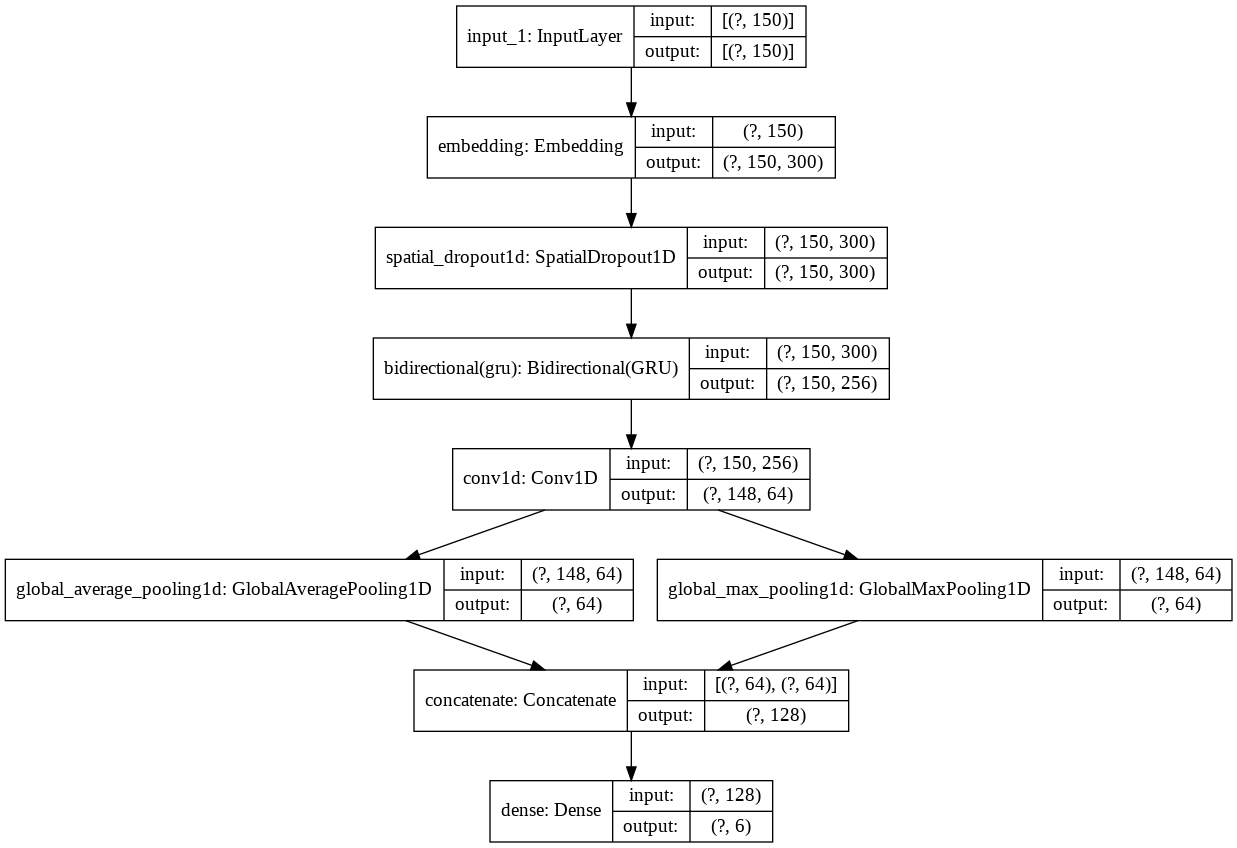

In [20]:
print(model.summary())
plot_model(model, show_shapes=True)

In [0]:
from sklearn.model_selection import train_test_split

x_tra, x_val, y_tra, y_val = train_test_split(x_train, y_train, train_size=0.95, random_state=233)

In [0]:
from tensorflow.keras.callbacks import Callback,ModelCheckpoint
from sklearn.metrics import roc_auc_score

class RocCallback(Callback):
  def __init__(self, validation_data):
    self.x_val = validation_data[0]
    self.y_val = validation_data[1]

  def on_epoch_end(self, epoch, logs={}):
    y_pred_val = self.model.predict(self.x_val)
    roc_val = roc_auc_score(self.y_val, y_pred_val)
    print(' - Roc-auc_val: %.6f' % roc_val)
    self.model.save_weights('model_%d_%.7f.h5' % (epoch+1, roc_val))
    return

roc = RocCallback(validation_data=(x_val, y_val))

In [0]:
# from tensorflow.core.protobuf import rewriter_config_pb2
# from tensorflow.compat.v1.keras.backend import set_session
# tf.keras.backend.clear_session()  # For easy reset of notebook state.

# config_proto = tf.compat.v1.ConfigProto()
# off = rewriter_config_pb2.RewriterConfig.OFF
# config_proto.graph_options.rewrite_options.arithmetic_optimization = off
# session = tf.compat.v1.Session(config=config_proto)
# set_session(session)

In [24]:
batch_size = 128
epochs = 4

hist = model.fit(x_tra, y_tra, batch_size=batch_size, callbacks=[roc], epochs=epochs, validation_data=(x_val, y_val), verbose=1)

Epoch 1/4
1185/1185 [==============================] - 1482s 1s/step - loss: 0.0531 - accuracy: 0.9221 - val_loss: 0.0434 - val_accuracy: 0.9699
Epoch 2/4
1185/1185 [==============================] - 1464s 1s/step - loss: 0.0378 - accuracy: 0.8791 - val_loss: 0.0449 - val_accuracy: 0.5026
Epoch 3/4
1185/1185 [==============================] - 1463s 1s/step - loss: 0.0319 - accuracy: 0.7865 - val_loss: 0.0453 - val_accuracy: 0.5128
Epoch 4/4
 112/1185 [=>............................] - ETA: 21:45 - loss: 0.0240 - accuracy: 0.7188

KeyboardInterrupt: ignored

In [0]:
model.load_weights('model_2_0.9892910.h5')
y_pred = model.predict(x_test, batch_size=1024)

In [0]:
submid = pd.DataFrame({'id': test['id']})
submission = pd.concat([submid, pd.DataFrame(y_pred, columns = list(train.columns)[2:-1])], axis=1)
submission.to_csv('submission.csv', index=False)